In [2]:
import tfRecordUtil as util
import os
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
#打开训练图片数据
filedir = "C:\\Users\\lenovo\\Documents\\tfstudy\\pic"
categorys = ["me","notme"]
imagearrays,labels,_ = util.image_arrays(categorys, filedir, True)
imagearrays.shape

(20, 1920, 1080, 1)

In [4]:
#打开测试图片数据
filedir = "C:\\Users\\lenovo\\Documents\\tfstudy\\pic\\meornotme"
testarrays,testlabels,_ = util.image_arrays(categorys, filedir, True)
testarrays.shape

(12, 1920, 1080, 1)

In [5]:
#储存图片到tfRecord（非必须步骤）
filedir = "C:\\Users\\lenovo\\Documents\\tfstudy\\pic\\tf"
tfname = "faces"
tftestname = "testfaces"
util.writeTF(imagearrays, labels, filedir, tfname)
util.writeTF(testarrays, testlabels, filedir, tftestname)

In [6]:
#从tfRecord中读取训练文件（非必须步骤）
shape = [1,1920,1080,1]
data,labels=util.get_all_records(os.path.join(filedir, tfname + ".tfrecords"), shape, 20)
labels = pd.get_dummies(labels)
labels.columns = [1, 2]
labels

Tensor("DecodeRaw:0", shape=(?,), dtype=float64)


,1,2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [7]:
#从tfRecord中读取测试文件（非必须步骤）
shape = [1,1920,1080,1]
testdata,testlabels=util.get_all_records(os.path.join(filedir, tftestname + ".tfrecords"), shape, 20)
testlabels = pd.get_dummies(labels)
testlabels.columns = [1, 2]
testlabels

Tensor("DecodeRaw_1:0", shape=(?,), dtype=float64)


,1,2
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [8]:
#查看图片数组shape
data.shape

(20, 1920, 1080, 1)

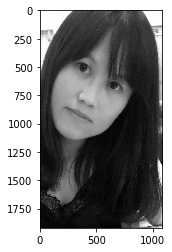

In [9]:
#展示其中一张图片
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(np.reshape(data[11],(1920,1080)), cmap ='gray')

In [32]:
#设置超参数
learning_rate = 0.01
epochs = 10000  #一共运行几大轮
batch_size = 256 #随机梯度下降，一小轮含多少张图片

#用来验证和计算模型评分的样本数
test_valid_size = 256

#神经网络参数
n_classess = 2 #只有两类，我和非我
drop_out = 0.75
weights = {
    #卷积层1 ： 11 * 11 数量48个 步长4
    "wc1" : tf.Variable(tf.truncated_normal([11, 11, 1, 48], dtype=tf.float32)),
    #卷积层2 ： 5 * 5 数量128个 步长1
    "wc2" : tf.Variable(tf.truncated_normal([5, 5, 48, 128], dtype=tf.float32)),
    #卷积层3： 3 * 3 数量192个 步长1
    "wc3" : tf.Variable(tf.truncated_normal([3, 3, 128, 192], dtype=tf.float32)),
    #卷积层4： 3 * 3 数量192个 步长1
    "wc4" : tf.Variable(tf.truncated_normal([3, 3, 192, 192], dtype=tf.float32)),
    #卷积层5： 3 * 3 数量128个 步长1
    "wc5" : tf.Variable(tf.truncated_normal([3, 3, 192, 128], dtype=tf.float32)),
    #全连接层1： 含1024个隐藏神经元
    "wd1" : tf.Variable(tf.truncated_normal([60 * 34 * 128, 1024], dtype=tf.float32)),
    #全连接层2:  含1024个隐藏神经元
    "wd2" : tf.Variable(tf.truncated_normal([1024, 1024], dtype=tf.float32)),
    #softmax全连接层： 含两个out神经元
    "out" : tf.Variable(tf.truncated_normal([1024, n_classess], dtype=tf.float32))
}

biases = {
    "bc1" : tf.Variable(tf.zeros([48], dtype=tf.float32)),
    "bc2" : tf.Variable(tf.zeros([128], dtype=tf.float32)),
    "bc3" : tf.Variable(tf.zeros([192], dtype=tf.float32)),
    "bc4" : tf.Variable(tf.zeros([192], dtype=tf.float32)),
    "bc5" : tf.Variable(tf.zeros([128], dtype=tf.float32)),
    "bd1" : tf.Variable(tf.zeros([1024], dtype=tf.float32)),
    "bd2" : tf.Variable(tf.zeros([1024], dtype=tf.float32)),
    "out" : tf.Variable(tf.zeros([n_classess], dtype=tf.float32))
}

In [11]:
def con2d(x, w , b, strides = 1, mode = "SAME"):
    x = tf.nn.conv2d(input=x, filter=w, 
                    strides = [1, strides, strides, 1], padding = mode)
    return tf.nn.relu(x)

In [12]:
def maxpool2d(x, k = 2, mode = "SAME"):
    x = tf.nn.max_pool(x, strides=[1, k, k, 1],
                      ksize = [1, k, k, 1], padding = mode)
    return x

In [13]:
def conv_net(x, weights, biases, dropout = 1):
    #卷积层1 1920 * 1080 to 480 * 270
    conv1 = con2d(x, weights["wc1"], biases["bc1"], strides=4)
    #池化 480 * 270  to 240 * 135
    conv1 = maxpool2d(conv1, k = 2)
    
    #卷积层2 240 * 135 to 240 * 135
    conv2 = con2d(conv1, weights["wc2"], biases["bc2"], strides=1)
    #池化 240 * 135 to 120 * 68
    conv2 = maxpool2d(conv2, k = 2)
    
    #卷积层3 120 * 68 to 120 * 68
    conv3 = con2d(conv2, weights["wc3"], biases["bc3"], strides=1)
    
    #卷积层4 120 * 68 to 120 * 68
    conv4 = con2d(conv3, weights["wc4"], biases["bc4"], strides=1)
    
    #卷积层5 120 * 68 to 120 * 68
    conv5 = con2d(conv4, weights["wc5"], biases["bc5"], strides=1)
    #池化 120 * 68 to 60 * 34
    conv5 = maxpool2d(conv5, k = 2)
    
    #全连接层1 60 * 34 * 128 to 1024
    fc1 = tf.reshape(conv5, shape = [-1, weights["wd1"].get_shape().as_list()[0]])
    fc1 = tf.matmul(fc1, weights["wd1"])
    fc1 = tf.add(fc1, biases["bd1"])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob=dropout)
    
    #全连接层2 1024 to 1024
    fc2 = tf.matmul(fc1, weights["wd2"])
    fc2 = tf.add(fc2, biases["bd2"])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc1, keep_prob=dropout)
    
    #输出层 1024 to 2
    out = tf.matmul(fc2, weights["out"])
    out = tf.add(out, biases["out"])
    return out

In [15]:
#tf placeholder 输入
x = tf.placeholder(tf.float32, [None, 1920, 1080, 1])
y = tf.placeholder(tf.float32, [None, n_classess])

keep_prob = tf.placeholder(tf.float32)

In [16]:
#损失与梯度下降
logits = conv_net(x, weights, biases, keep_prob)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#准确率
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [17]:
#准备训练数据
def next_batch(batchsize, x, y):
    n_batches = x.shape[0] // batchsize
    x = x[:n_batches * batch_size, :, : , :]
    y = y.iloc[:n_batches * batchsize, :]
    
    for n in range(0, len(y), batchsize):
        batch_x = x[n : n + batchsize, :, :, :]
        batch_y = y.iloc[n : n + batchsize, :]
        yield batch_x, batch_y

In [35]:
#启动会话，开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        accur = 0
        for batch_x, batch_y in next_batch(batch_size, data, labels):
            feed = {
                x : batch_x,
                y : batch_y,
                keep_prob : drop_out
            }
            
            feed_valid = {
                x : batch_x,
                y : batch_y,
                keep_prob : 1
            }
            
            sess.run(optimizer, feed_dict=feed)
            valid_accur = sess.run(accuracy, feed_dict=feed_valid)
            accur += valid_accur
            
        print("第",epoch, "轮，准确率为：", accur/(data.shape[0]// batch_size))

    #测试集准确率
    test_acc = sess.run(accuracy, feed_dict={
        x: testdata,
        y: testlabels,
        keep_prob :1.})
    print('Testing Accuracy: {}'.format(test_acc)) 

KeyboardInterrupt: 